<a href="https://colab.research.google.com/github/cplazaibarra/Curso-Python/blob/master/softlog_neuronal_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos (asegúrate de cambiar la ruta si es necesario)
url = '/content/drive/My Drive/base_venta_v3.csv'
df = pd.read_csv(url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Diccionario para almacenar los modelos entrenados, parte vacio
modelos_sku = {}



In [ ]:
# 2. Preprocesamiento y entrenamiento de modelos por SKU
for sku in df['Sku'].unique():
    # Filtrar los datos por SKU
    datos_sku = df[df['Sku'] == sku]
    ventas = datos_sku['Venta-cant'].values.reshape(-1, 1)  # Asumiendo que la columna de ventas se llama 'Venta-cant'

    # Escalado de los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    ventas_scaled = scaler.fit_transform(ventas)

    # Crear secuencias de datos (X_train, y_train)
    def crear_secuencias(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 10  # Número de días previos para usar como input en la predicción
    X, y = crear_secuencias(ventas_scaled, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Requerido para LSTM

    # Crear el modelo LSTM
    model = Sequential()
    model.add(Input(shape=(look_back, 1)))  # Definir la forma de entrada aquí
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))

    # Compilar el modelo (es necesario antes de entrenar)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)  # Ajusta epochs y batch_size según sea necesario

    # Guardar el modelo entrenado y el scaler para el SKU actual
    modelos_sku[sku] = {'modelo': model, 'scaler': scaler, 'look_back': look_back}


Ingresa el SKU que deseas predecir: 260
Ingresa el número de días futuros que deseas predecir: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

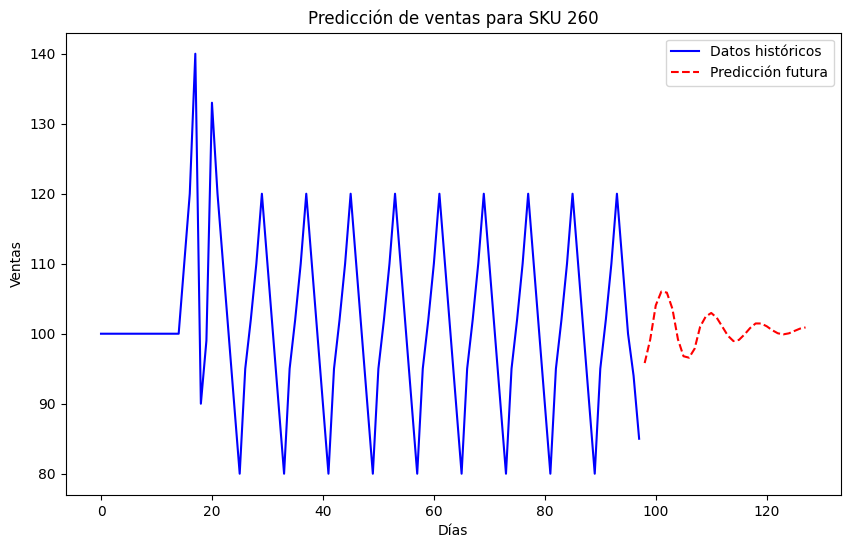

In [ ]:
# 3. Función para predecir ventas futuras
def predecir_ventas_futuras(sku, dias_futuros):
    if sku not in modelos_sku:
        print(f"El SKU {sku} no está disponible.")
        return

    # Obtener el modelo y el scaler del SKU
    modelo_info = modelos_sku[sku]
    model = modelo_info['modelo']
    scaler = modelo_info['scaler']
    look_back = modelo_info['look_back']

    # Últimos datos de ventas para usar como input para la predicción
    datos_sku = df[df['Sku'] == sku]
    ventas = datos_sku['Venta-cant'].values.reshape(-1, 1)
    ventas_scaled = scaler.transform(ventas)

    # Tomar los últimos 'look_back' días para empezar a predecir
    secuencia_input = ventas_scaled[-look_back:]
    secuencia_input = np.reshape(secuencia_input, (1, look_back, 1))

    # Predecir para los próximos 'dias_futuros'
    predicciones = []
    for _ in range(dias_futuros):
        prediccion = model.predict(secuencia_input)
        predicciones.append(prediccion[0, 0])

        # Actualizar la secuencia con la nueva predicción (ajustando dimensiones)
        secuencia_input = np.append(secuencia_input[:, 1:, :], [[[prediccion[0, 0]]]], axis=1)

    # Invertir el escalado de las predicciones para volver a las ventas originales
    predicciones = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1))

    return predicciones.flatten()

# 4. Preguntar al usuario por el SKU y los días a predecir
sku_input = int(input("Ingresa el SKU que deseas predecir: "))
dias_futuros = int(input("Ingresa el número de días futuros que deseas predecir: "))

# 5. Llamar a la función para predecir y mostrar resultados
predicciones = predecir_ventas_futuras(sku_input, dias_futuros)

if predicciones is not None:
    print(f"Predicciones para el SKU {sku_input} para los próximos {dias_futuros} días:")
    for dia, prediccion in enumerate(predicciones, 1):
        print(f"Día {dia}: {prediccion:.2f} ventas")

  # Calcular y mostrar la venta total de los días futuros
    total_ventas_futuras = np.sum(predicciones)
    print(f"\nVenta total pronosticada para los próximos {dias_futuros} días: {total_ventas_futuras:.2f} ventas")



       # 6. Graficar los datos históricos y los pronosticados
    datos_sku = df[df['Sku'] == sku_input]
    ventas_historicas = datos_sku['Venta-cant'].values

    # Crear los índices para los datos futuros
    indices_futuros = np.arange(len(ventas_historicas), len(ventas_historicas) + dias_futuros)

    plt.figure(figsize=(10, 6))

    # Graficar los datos históricos
    plt.plot(np.arange(len(ventas_historicas)), ventas_historicas, color='blue', label='Datos históricos')

    # Graficar las predicciones futuras
    plt.plot(indices_futuros, predicciones, color='red', linestyle='--', label='Predicción futura')

    # Añadir título y etiquetas
    plt.title(f'Predicción de ventas para SKU {sku_input}')
    plt.xlabel('Días')
    plt.ylabel('Ventas')
    plt.legend()

    # Mostrar la gráfica
    plt.show()